#### The CrisisMMD multimodal Twitter dataset consists of several thousands of manually annotated tweets and images collected during seven major natural disasters

#### Task 1: Informative vs Not informative
* Informative
* Not informative

#### Task 2: Humanitarian categories
* Affected individuals
* Infrastructure and utility damage
* Injured or dead people
* Missing or found people
* Rescue, volunteering or donation effort
* Vehicle damage
* Other relevant information
* Not humanitarian
   
#### Task 3: Damage severity assessment
* Severe damage
* Mild damage
* Little or no damage

Each TSV file in this directory contains the following columns, separated by a tab:

* tweet_id: corresponds to the actual tweet id from Twitter.
* image_id: corresponds to a combination of a "tweet_id" and an index concatenated with an underscore. The integer indices represent different images associated with a given tweet.
* text_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet text.
* text_info_conf: corresponds to the confidence score associated with the "text_info" label of a given tweet text.
* image_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet image.
* image_info_conf: corresponds to the confidence score associated with the "image_info" label  of a given tweet image.
* text_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet text.
* text_human_conf: corresponds to the confidence score associated with the "text_human" label of a given tweet text.
* image_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet image.
* image_human_conf: corresponds to the confidence score associated with the "image_human" label of a given tweet image.
* image_damage: corresponds to the damage severity assessment label (see the list of damage severity assessment task labels above) assigned to a given tweet image.
* image_damage_conf: corresponds to the confidence score associated with the "image_damage" label of a given tweet image.
* tweet_text: corresponds to the original text of a given tweet as downloaded from Twitter.
* image_url: corresponds to the original image URL of a given tweet provided by Twitter.
* image_path: corresponds to the relative path of an image inside the "data_image" folder for a given tweet.

Note that there are empty (i.e., null) entries in the TSV files that simply indicate "not applicable" cases. For example, for a given pair of tweet text and image, if neither the text nor the image is labeled as informative (i.e., text_info != informative & image_info != informative), then the given tweet text/image pair is excluded from the rest of the annotation tasks (i.e., humanitarian and damage severity assessment tasks). Similarly, for the damage severity assessment task, we included only the subset of images that were labeled as "infrastructure and utility damage" and excluded all other images from the task. In such cases, we have empty (i.e., null) entries in our annotation tables.


In [1]:
import pandas as pd
import numpy as np

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [3]:
import textblob
import tweepy
from textblob import TextBlob
import os
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Load into dataframe
dataset = pd.read_csv("mexico_earthquake_final_data.tsv", sep='\t')

In [6]:
print("The dataset has", dataset.shape[1], "variables describing", dataset.shape[0],"tuples")

The dataset has 15 variables describing 1380 tuples


In [7]:
dataset.head()

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,910523364154003456,910523364154003456_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,RT @FCBarcelona: Our solidarity with the victi...,http://pbs.twimg.com/media/DKLLdbyW0AASG2R.jpg,data_image/mexico_earthquake/20_9_2017/9105233...
1,910523388598280192,910523388598280192_0,informative,1.0000,informative,0.6720,injured_or_dead_people,1.0000,infrastructure_and_utility_damage,0.6720,dont_know_or_cant_judge,0.4174,Mexico earthquake: Many children killed at pri...,http://pbs.twimg.com/media/DKLUMbJV4AACuFU.jpg,data_image/mexico_earthquake/20_9_2017/9105233...
2,910523397448314882,910523397448314882_0,not_informative,0.6643,not_informative,1.0000,not_humanitarian,0.6643,not_humanitarian,1.0000,NaN,NaN,Obamaâ€™s Response To The Earthquake In #Mexic...,http://pbs.twimg.com/media/DKLUND8WAAAHgON.jpg,data_image/mexico_earthquake/20_9_2017/9105233...
3,910523398144397312,910523398144397312_0,informative,0.9282,informative,1.0000,rescue_volunteering_or_donation_effort,0.9282,rescue_volunteering_or_donation_effort,1.0000,NaN,NaN,RT @AmichaiStein1: #BREAKING: Israel search &a...,http://pbs.twimg.com/media/DKK1CuDWsAAX5Vk.jpg,data_image/mexico_earthquake/20_9_2017/9105233...
4,910523398144397312,910523398144397312_1,informative,0.9282,informative,0.6943,rescue_volunteering_or_donation_effort,0.9282,rescue_volunteering_or_donation_effort,0.6943,NaN,NaN,RT @AmichaiStein1: #BREAKING: Israel search &a...,http://pbs.twimg.com/media/DKK1DyDXkAABvBX.jpg,data_image/mexico_earthquake/20_9_2017/9105233...


In [8]:
dataset.shape

(1380, 15)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           1380 non-null   int64  
 1   image_id           1380 non-null   object 
 2   text_info          1380 non-null   object 
 3   text_info_conf     1380 non-null   float64
 4   image_info         1380 non-null   object 
 5   image_info_conf    1380 non-null   float64
 6   text_human         1380 non-null   object 
 7   text_human_conf    1380 non-null   float64
 8   image_human        1380 non-null   object 
 9   image_human_conf   1380 non-null   float64
 10  image_damage       182 non-null    object 
 11  image_damage_conf  182 non-null    float64
 12  tweet_text         1380 non-null   object 
 13  image_url          1380 non-null   object 
 14  image_path         1380 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 161.8+ KB


The variables are a mix of **categorical** and **continuous** types.

There is a memory usage of 186 KB for the entire dataset.

In [10]:
dataset.sample(5)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
114,910538724894760960,910538724894760960_0,not_informative,0.7137,not_informative,1.0000,not_humanitarian,0.7137,not_humanitarian,1.0000,NaN,NaN,RT @BarcaSpiral: Our thoughts are with Mexico ...,http://pbs.twimg.com/media/DKKntv6W0AEMPdA.jpg,data_image/mexico_earthquake/20_9_2017/9105387...
200,910559231916560385,910559231916560385_0,informative,0.6657,informative,0.6619,other_relevant_information,0.6657,affected_individuals,0.6619,NaN,NaN,"Terror, Chaos, and Solidarity as Another Earth...",http://pbs.twimg.com/media/DKL0y57WsAAMkgX.jpg,data_image/mexico_earthquake/20_9_2017/9105592...
302,910617832852938752,910617832852938752_0,not_informative,0.7149,not_informative,0.6712,not_humanitarian,0.7149,not_humanitarian,0.6712,NaN,NaN,Mexico's 4-legged Heroes aka Disaster Dog's - ...,http://pbs.twimg.com/media/DKMqFuPVwAASeAv.jpg,data_image/mexico_earthquake/20_9_2017/9106178...
953,912092784408002560,912092784408002560_0,informative,0.6500,informative,1.0000,infrastructure_and_utility_damage,0.6500,infrastructure_and_utility_damage,1.0000,severe_damage,0.7037,Los Angeles â€˜buildings will be DEATH BOXES i...,http://pbs.twimg.com/media/DKhni7vX0AEJrNY.jpg,data_image/mexico_earthquake/24_9_2017/9120927...
472,910696337234120704,910696337234120704_0,informative,0.3427,informative,0.6500,vehicle_damage,0.3427,infrastructure_and_utility_damage,0.6500,severe_damage,1.0000,Anchorage woman with close ties to latest Mexi...,http://pbs.twimg.com/media/DKNvcdkU8AEa4Qw.jpg,data_image/mexico_earthquake/21_9_2017/9106963...


In [11]:
dataset.drop(['tweet_id','image_id','image_url','image_path'], axis = 1, inplace = True) #dropping key column, it's unnecessary for  the analysis and prediction

In [12]:
categorical = [col for col in dataset.columns if dataset.dtypes[col] =='object']
numericals  = [col for col in dataset.columns if dataset.dtypes[col] !='object']
print("No of categorical features are: ",len(categorical),"\nNo of numerical features are: ",len(numericals))

No of categorical features are:  6 
No of numerical features are:  5


In [13]:
# function to describe the field dtype, missing and unique values
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value 1'] = df.iloc[0].values
    summary['Sample Value 2'] = df.iloc[1].values
    return summary

description(dataset)

,Name,dtypes,Missing,Uniques,Sample Value 1,Sample Value 2
0,text_info,object,0,2,not_informative,informative
1,text_info_conf,float64,0,424,1.0,1.0
2,image_info,object,0,2,not_informative,informative
3,image_info_conf,float64,0,348,1.0,0.672
4,text_human,object,0,8,not_humanitarian,injured_or_dead_people
5,text_human_conf,float64,0,424,1.0,1.0
6,image_human,object,0,8,not_humanitarian,infrastructure_and_utility_damage
7,image_human_conf,float64,0,348,1.0,0.672
8,image_damage,object,1198,4,NaN,dont_know_or_cant_judge
9,image_damage_conf,float64,1198,41,NaN,0.4174


In [14]:
dataset.describe()

,text_info_conf,image_info_conf,text_human_conf,image_human_conf,image_damage_conf
count,1380.000000,1380.000000,1380.000000,1380.000000,182.000000
mean,0.826756,0.848417,0.826756,0.848417,0.845351
std,0.184276,0.188521,0.184276,0.188521,0.181270
min,0.277500,0.334800,0.277500,0.334800,0.338600
25%,0.667400,0.671100,0.667400,0.671100,0.676800
50%,0.835250,1.000000,0.835250,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


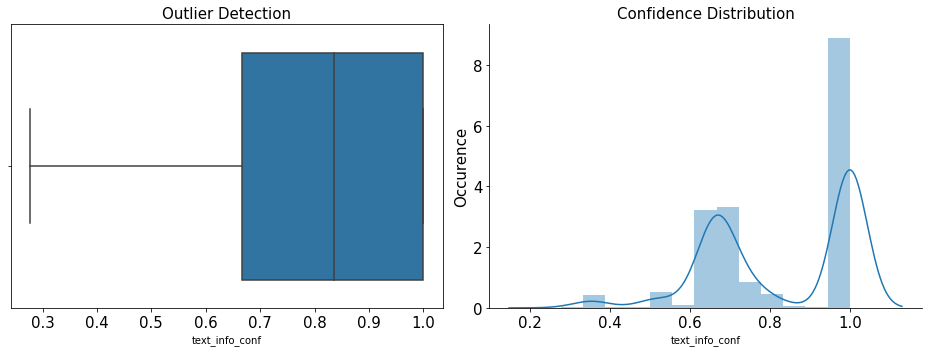

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


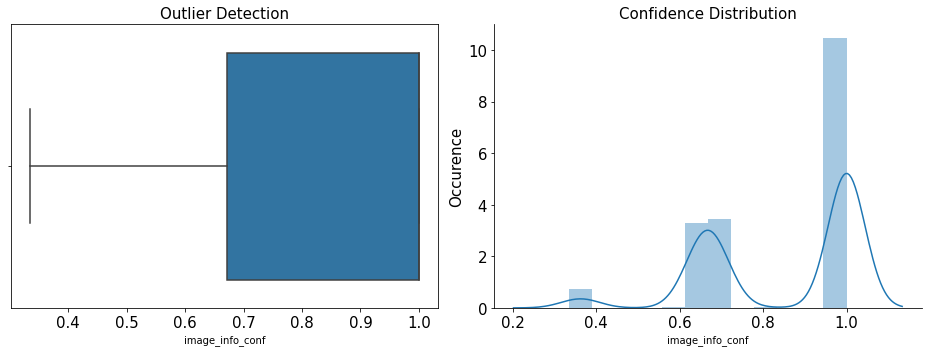

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


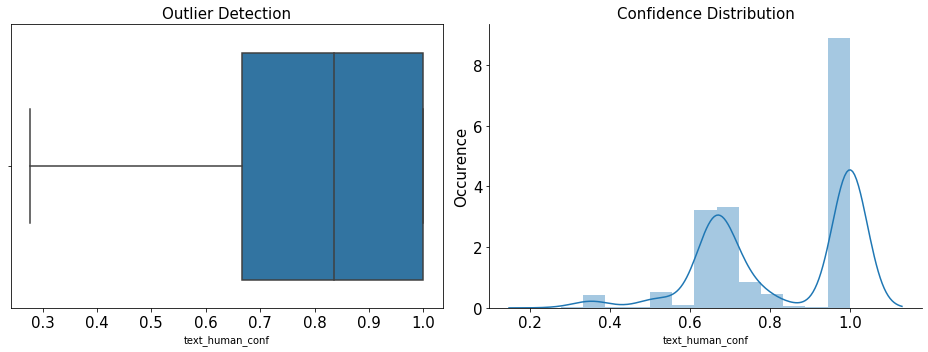

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


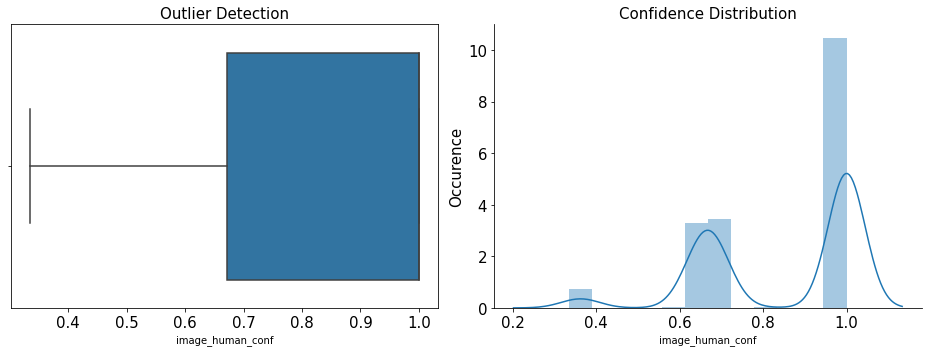

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


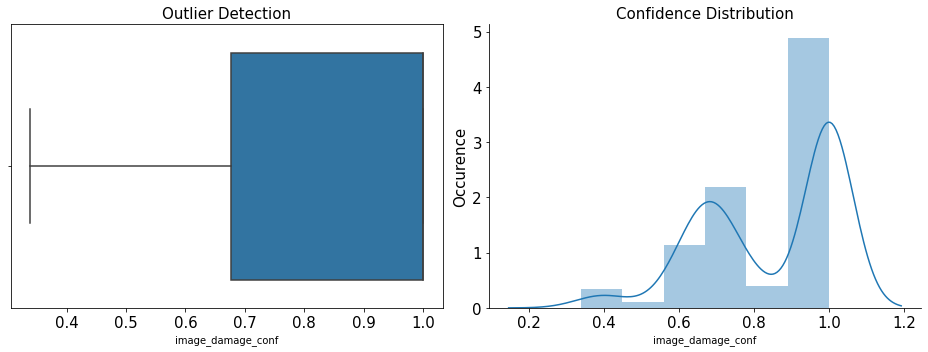

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_damage_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_damage_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


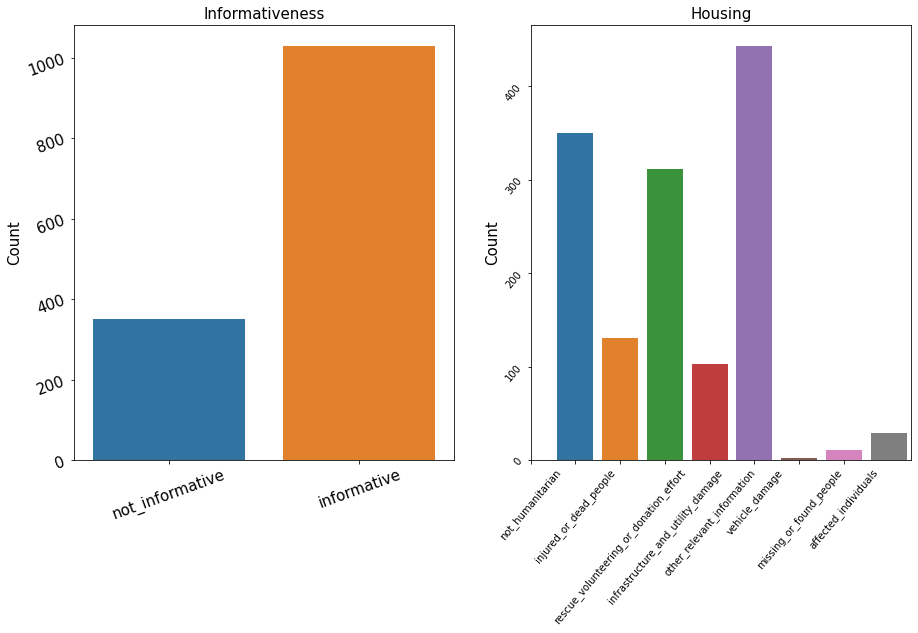

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
sns.countplot(x = 'text_info', data = dataset, ax = ax1)
ax1.set_title('Informativeness', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xticks(range(len(dataset.text_info.unique())))
ax1.tick_params(labelsize=15,rotation=20)


sns.countplot(x = 'text_human', data = dataset, ax = ax2)
ax2.set_title('Housing', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xticks([-1,0,1,2,3,4,5,6])
ax2.set_xticklabels(dataset.text_human.unique())

ax2.tick_params(labelsize=10,rotation=50)

plt.subplots_adjust()

In [21]:
categorical.pop()
for i in categorical:
    print(i,"has following categories with counts as follows")
    print(dataset[i].value_counts(),"\n\n")

text_info has following categories with counts as follows
informative        1030
not_informative     350
Name: text_info, dtype: int64 


image_info has following categories with counts as follows
informative        841
not_informative    539
Name: image_info, dtype: int64 


text_human has following categories with counts as follows
other_relevant_information                443
not_humanitarian                          350
rescue_volunteering_or_donation_effort    311
injured_or_dead_people                    131
infrastructure_and_utility_damage         103
affected_individuals                       29
missing_or_found_people                    11
vehicle_damage                              2
Name: text_human, dtype: int64 


image_human has following categories with counts as follows
not_humanitarian                          539
rescue_volunteering_or_donation_effort    446
infrastructure_and_utility_damage         182
other_relevant_information                104
affected_individu

In [22]:
twitter = pd.DataFrame(columns=['tweets'])
twitter['tweets'] = dataset['tweet_text']

In [23]:
twitter.tweets.drop_duplicates(inplace = True)
type(twitter.tweets)

pandas.core.series.Series

In [24]:
stopwords = set(STOPWORDS)
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['tweets']))

(-0.5, 399.5, 199.5, -0.5)

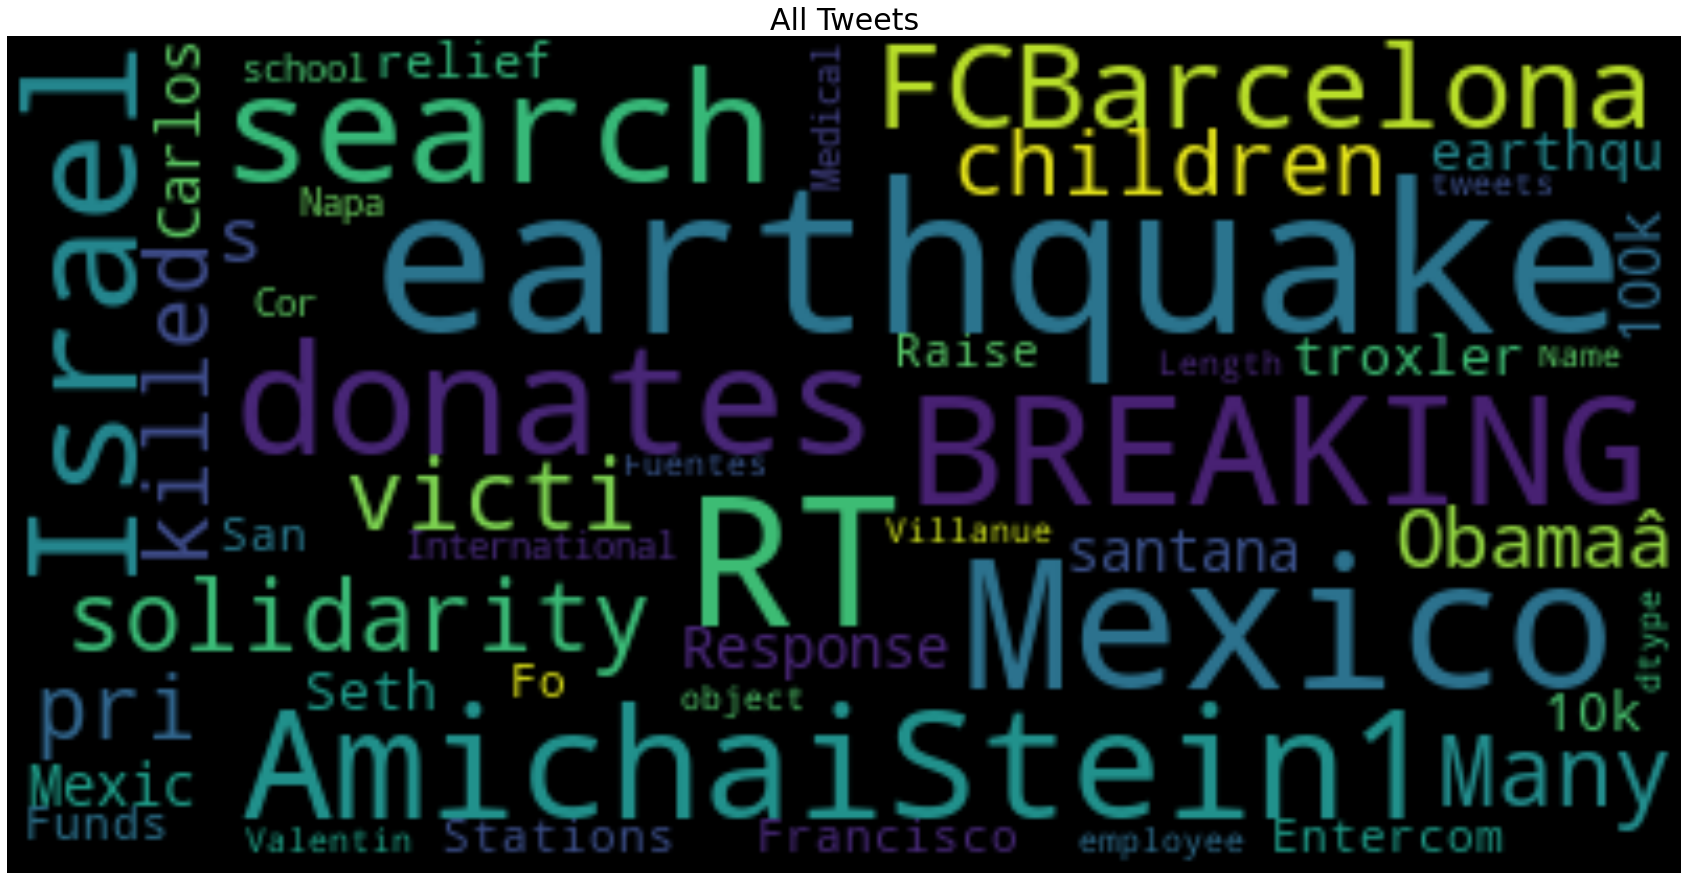

In [25]:
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [26]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text

twitter['clean_text'] = twitter['tweets'].apply(lambda x: remove_punct(x))

#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

twitter['clean_text'] = twitter['clean_text'].apply(lambda x: tokenization(x.lower()))

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: remove_stopwords(x))

#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: stemming(x))


In [27]:
twitter

,tweets,clean_text
0,RT @FCBarcelona: Our solidarity with the victi...,"[rt, fcbarcelona, solidar, victim, earthquak, ..."
1,Mexico earthquake: Many children killed at pri...,"[mexico, earthquak, mani, children, kill, prim..."
2,Obamaâ€™s Response To The Earthquake In #Mexic...,"[obamaâ, respons, earthquak, mexicoc, real, pr..."
3,RT @AmichaiStein1: #BREAKING: Israel search &a...,"[rt, amichaistein1, break, israel, search, amp..."
4,RT @AmichaiStein1: #BREAKING: Israel search &a...,"[rt, amichaistein1, break, israel, search, amp..."
...,...,...
1375,Carlos santana donates $100k to mexico earthqu...,"[carlo, santana, donat, 1k, mexico, earthquak,..."
1376,Seth troxler donates 10k to earthquake relief ...,"[seth, troxler, donat, 1k, earthquak, relief, ..."
1377,Entercom/San Francisco Stations Raise Funds Fo...,"[entercomsan, francisco, station, rais, fund, ..."
1378,Mexico Earthquakes | International Medical Cor...,"[mexico, earthquak, intern, medic, corp, https..."


(-0.5, 399.5, 199.5, -0.5)

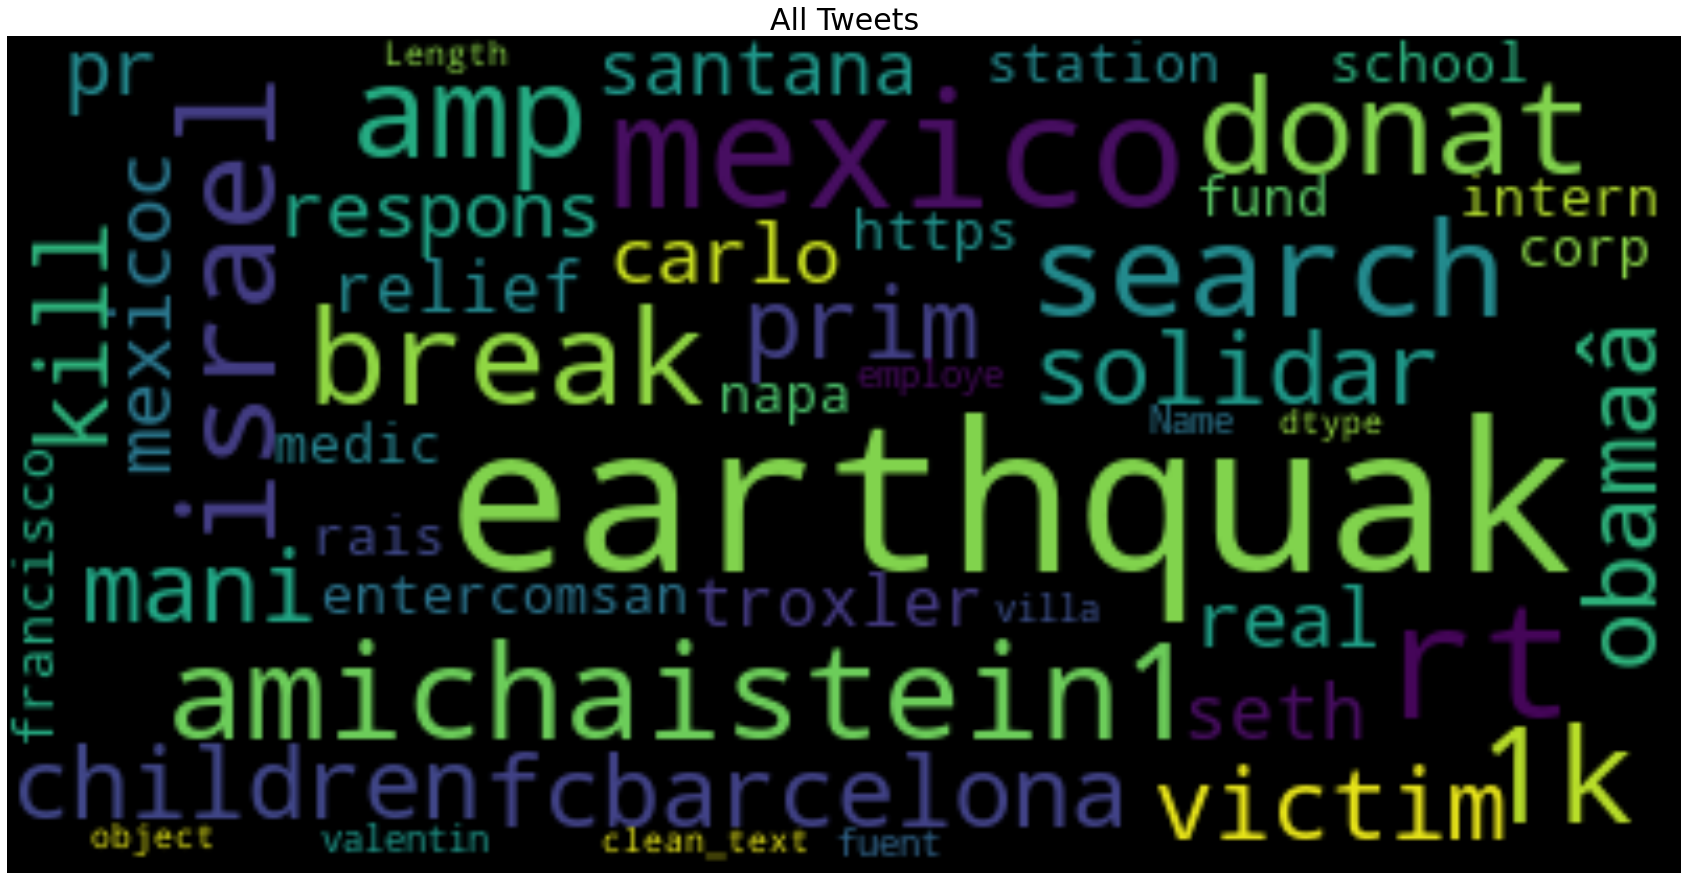

In [28]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['clean_text']))
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [29]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer='word') 
countVector = countVectorizer.fit_transform(twitter['tweets'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

1380 Number of reviews has 5560 words
['00', '000', '002jpkg5qx', '00am', '01', '014nlvwf6l', '02', '02mo', '03', '04hev2y5a5', '05', '06', '06am', '06mxpnqzqh', '08rrv8gr57', '09', '0925', '0a4kbf4hwo', '0ajszvwv2u', '0btilvlcvk', '0bvcmaxfpx', '0ci9a6sya9', '0ct3lzj1m2', '0ipqd4bua7', '0j1zgxfjmu', '0md2wl61ga', '0orhf6yuyy', '0p9x7zhmmu', '0sfh9gioro', '0terj3dk7y', '0tnwbxty70', '0uv0iw7hf6', '0vga5lj758', '0xt40yrcej', '0xtmtgxgga', '0yyfohygeg', '0zgrchfn6e', '10', '100', '100k', '1027kiisfm', '104', '107yobfwjw', '10k', '10news', '10zpykqiyt', '11', '119km', '11km', '12', '125k', '13', '130', '138', '14', '145', '14pm', '14â', '15', '15am', '15labc7qao', '16', '17', '17ta3v4uud', '17yltwnmmw', '19', '1985', '19th', '1avcwjq0mk', '1aw1208hji', '1bcdxzutoa', '1ckukf1kb0', '1dmllmyfic', '1eiw6hqz4o', '1fob8nd5nd', '1fofzs2yh1', '1guhns7frh', '1hje6vejwv', '1hurn8ianx', '1hxjoxwtql', '1hyvag1syn', '1ipteyboro', '1kamw6gb8p', '1lx7ysrac1', '1lztpaldng', '1m', '1mfa8v5ylk', '1mijdupr7

In [30]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:20]

,0
https,2339
mexico,1120
earthquake,1070
in,442
the,366
to,343
of,303
rt,226
city,216
for,200


(-0.5, 399.5, 199.5, -0.5)

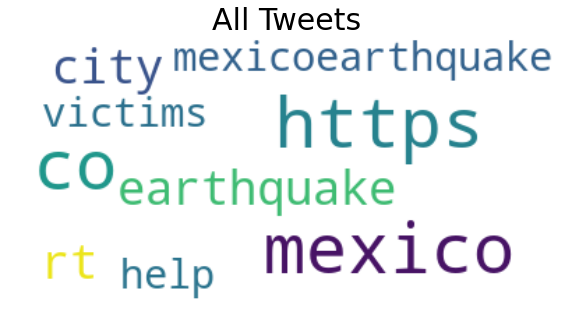

In [31]:
wc = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(str(countdf))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')